In [51]:
import pandas as pd
import numpy as np 
import torch
from torch.utils.data import Dataset
from PIL import Image
from transformers import TrOCRProcessor
from torch.utils.data import DataLoader
from transformers import VisionEncoderDecoderModel
import torch
from evaluate import load
import logging
import matplotlib.pyplot as plt 
# Set logging level for transformers to ERROR (or CRITICAL to suppress more)
logging.getLogger("transformers").setLevel(logging.ERROR)
from src.inference import ImageToWordModel 
import cv2 
from mltu.utils.text_utils import  get_cer, get_wer 
from tqdm.notebook import tqdm

In [2]:
model = VisionEncoderDecoderModel.from_pretrained(f"microsoft/trocr-small-handwritten")
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")

Number of parameters: 61596672


### Comparing models for differents epochs
This code uses models saved in "results/pretrained" by the finetuning notebook. As there are 15 of them and they are big, we can't it directly upload them on git. So run "fine_tune_trocr.ipynb" to generate them. 

However, we provide the best performing model in the following link : https://drive.google.com/drive/folders/12I3GhCDFewbT3f5TpPIMebGkLSHleFem?usp=sharing. 


If you download it and put it in the "results/pretrained" folder, you can run the next section of the code to verify the performence of the majority voting algorithm.


In [3]:
# Custom dataset class for TrOCR (Transformer-based Optical Character Recognition) 
class TrOCRDataset(Dataset):

    # Constructor to initialize the dataset with root directory, dataframe, processor, and optional max target length
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    # Return the total number of samples in the dataset (i.e., the number of rows in the DataFrame)
    def __len__(self):
        return len(self.df)

    # Retrieve an individual sample (image and its corresponding text) from the dataset
    def __getitem__(self, idx):
        # Get file name + text 
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # Some file names end with jp instead of jpg, the two lines below fix this
        if file_name.endswith('jp'):
          file_name = file_name + 'g'
        # Prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # Add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # Important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [4]:
# Function to evaluate the model's performance on a given dataset using CER and WER metrics
def evaluate(model_path,processor_path, dataset_path):
    
    df = pd.DataFrame(np.load(dataset_path)) 
    df.rename(columns={0: "file_name", 1: "text"}, inplace=True)
    processor = TrOCRProcessor.from_pretrained(processor_path, quiet=True)
    test_dataset = TrOCRDataset(root_dir='',df=df,processor=processor)

    test_dataloader = DataLoader(test_dataset, batch_size=8)
    
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model = VisionEncoderDecoderModel.from_pretrained(model_path)
    model = model.to(device)
    
    cer = load("cer")
    wer = load("wer") 
    print("Running evaluation...")

    for batch in test_dataloader:
        # Predict using generate
        pixel_values = batch["pixel_values"].to(device)
        outputs = model.generate(pixel_values)

        # Decode
        pred_str = processor.batch_decode(outputs, skip_special_tokens=True)
        labels = batch["labels"]
        labels[labels == -100] = processor.tokenizer.pad_token_id
        label_str = processor.batch_decode(labels, skip_special_tokens=True)
        
        # Add batch to metric
        cer.add_batch(predictions=pred_str, references=label_str)
        wer.add_batch(predictions=pred_str, references=label_str) 
    
    return {"cer": cer.compute(), "wer": wer.compute()} 

In [6]:
max_epochs = 15

test_metrics_list = []
val_metrics_list = []

for i in range(1,max_epochs+1):
    # Evaluate the model on the test set for the current epoch
    test_metrics = evaluate(f"results/pretrained/small_epochs={i}_fulldata", 
                        "microsoft/trocr-small-handwritten", 
                        "data/testset.npy")
    
    # Evaluate the model on the validation set for the current epoch
    val_metrics = evaluate(f"results/pretrained/small_epochs={i}_fulldata",
                          "microsoft/trocr-small-handwritten",
                          "data/valset.npy")
    
    test_metrics_list.append(test_metrics)
    val_metrics_list.append(val_metrics)

    print(f"Epoch {i} - Val CER: {val_metrics['cer']}, Val WER: {val_metrics['wer']}") 
    print(f"Epoch {i} - Test CER: {test_metrics['cer']}, Test WER: {test_metrics['wer']}")

Running evaluation...
Running evaluation...
Epoch 1 - Val CER: 0.3571221351900203, Val WER: 0.5517241379310345
Epoch 1 - Test CER: 0.7466266866566716, Test WER: 0.8785425101214575
Running evaluation...
Running evaluation...
Epoch 2 - Val CER: 0.24949231215549753, Val WER: 0.4288240495137047
Epoch 2 - Test CER: 0.4782608695652174, Test WER: 0.6558704453441295
Running evaluation...
Running evaluation...
Epoch 3 - Val CER: 0.19727299100667248, Val WER: 0.38461538461538464
Epoch 3 - Test CER: 0.39730134932533734, Test WER: 0.6032388663967612
Running evaluation...
Running evaluation...
Epoch 4 - Val CER: 0.1560777487670438, Val WER: 0.3147656940760389
Epoch 4 - Test CER: 0.32533733133433285, Test WER: 0.5141700404858299
Running evaluation...
Running evaluation...
Epoch 5 - Val CER: 0.12097476066144473, Val WER: 0.2519893899204244
Epoch 5 - Test CER: 0.20839580209895053, Test WER: 0.3967611336032389
Running evaluation...
Running evaluation...
Epoch 6 - Val CER: 0.14012184508268058, Val WER: 

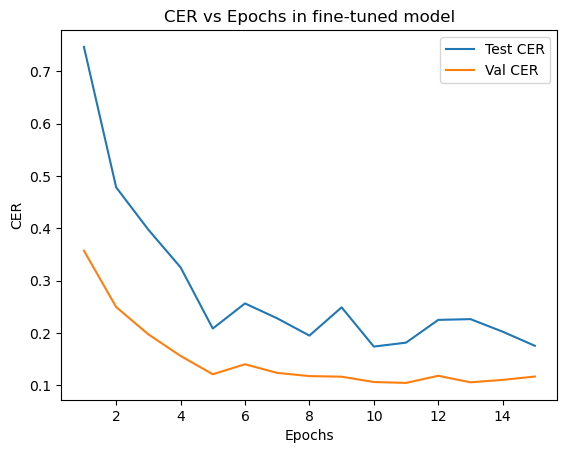

In [11]:
test_cers = [
    test_metrics["cer"] for test_metrics in test_metrics_list
]

val_cers = [
    val_metrics["cer"] for val_metrics in val_metrics_list
]

plt.plot(range(1,max_epochs+1), test_cers, label="Test CER")
plt.plot(range(1,max_epochs+1), val_cers, label="Val CER")
# Name the x-axis
plt.xlabel("Epochs")
# Name the y-axis
plt.ylabel("CER")
plt.title("CER vs Epochs in fine-tuned model")
plt.legend()
plt.show()

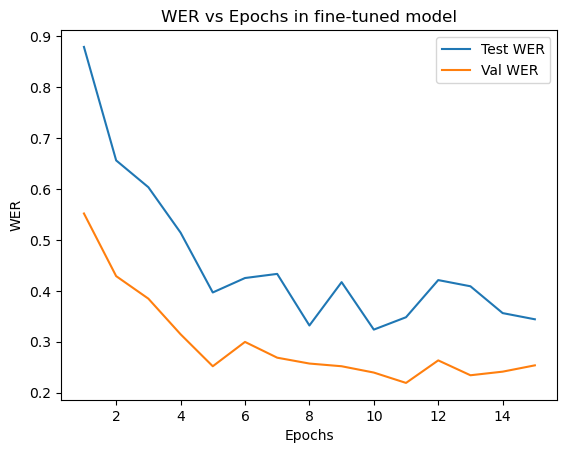

In [13]:
test_wers = [
    test_metrics["wer"] for test_metrics in test_metrics_list
]

val_wers = [
    val_metrics["wer"] for val_metrics in val_metrics_list
]

plt.plot(range(1,max_epochs+1), test_wers, label="Test WER")
plt.plot(range(1,max_epochs+1), val_wers, label="Val WER")
# Name the x-axis
plt.xlabel("Epochs")
# Name the y-axis
plt.ylabel("WER")
plt.title("WER vs Epochs in fine-tuned model")
plt.legend()

In [16]:
# Find index for which cer loss is minimum 
val_cer_list = [val_metrics['cer'] for val_metrics in val_metrics_list]
min_cer_index = val_cer_list.index(min(val_cer_list))

print("The best model(by validation cer) is at epoch: ", min_cer_index+1) 
print("--------- TrOCR results ---------")
print("Val CER: ", val_cers[min_cer_index])
print("Val WER: ", val_wers[min_cer_index])
print("Test CER: ", test_cers[min_cer_index])
print("Test WER: ", test_wers[min_cer_index])

The best model(by validation cer) is at epoch:  11
--------- TrOCR results ---------
Val CER:  0.10443864229765012
Val WER:  0.21927497789566755
Test CER:  0.18140929535232383
Test WER:  0.3481781376518219


The best performing model is obtained after 11 epochs. 

### Majority voting algorithm

In [17]:
# Load the best model 
best_model = VisionEncoderDecoderModel.from_pretrained(f"results/pretrained/small_epochs={min_cer_index+1}_fulldata")
best_model = best_model.to("mps") 

In [70]:
# Function that performs majority voting to combine predictions from three models
def majority_vote(htrnet, cnn_bilstm_mltu, trocr, trocr_process, image):
    """
    In case of tie, cnn_bilstm_mltu is given preference. 
    """

    htrnet_pred = htrnet.predict(image) 
    cnn_bilstm_mltu_pred = cnn_bilstm_mltu.predict(image)
    trocr_pred = trocr.generate(
        trocr_process(image, return_tensors="pt").pixel_values
    )

    trocr_pred = trocr_process.batch_decode(trocr_pred, skip_special_tokens=True)
    trocr_pred = trocr_pred[0]

    freq_dict = {}
    for pred in [htrnet_pred, cnn_bilstm_mltu_pred, trocr_pred]:
        if pred in freq_dict:
            freq_dict[pred] += 1
        else:
            freq_dict[pred] = 1

    max_freq = max(freq_dict.values())
    max_freq_preds = [k for k, v in freq_dict.items() if v == max_freq]

    if len(max_freq_preds) == 1:
        return max_freq_preds[0]
    else:
        # In case of a tie, return the cnn_bilstm_mltu prediction (given preference)
        return cnn_bilstm_mltu_pred
    
# Function to evaluate models using majority voting on a dataset
def evaludate_with_majority_vote(datapath):
    
    htr_net = ImageToWordModel("results/htr_full_data/model.onnx") 
    cnn_bilstm_mltu = ImageToWordModel("results/cnn_bilstm_mltu_all_data/model.onnx") 
    processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-handwritten", quiet=True)
        
    if "csv" in datapath:
        df = pd.read_csv(datapath).values.tolist()
    elif "npy" in datapath:  
        df = np.load(datapath).tolist() 
    else : 
        raise ValueError("Invalid data path. Please provide a csv or npy file")
    
    cer = [] 
    wer = [] 

    # Iterate over each image-path and label pair in the dataset
    for image_path, label in tqdm(df):
        image = cv2.imread(image_path.replace("\\", "/"))
        
        prediction_text = majority_vote(
            htr_net,
            cnn_bilstm_mltu,
            best_model.to("cpu"), 
            processor, 
            image
        )
            
        cer.append(get_cer(prediction_text, label))
        wer.append(get_wer(prediction_text, label)) 
    
    return np.average(cer), np.average(wer) 

In [71]:
test_cer_maj,test_wer_maj= evaludate_with_majority_vote("data/testset.npy")

print("Test CER with majority vote: ", test_cer_maj)
print("Test WER with majority vote: ", test_wer_maj)

val_cer_maj, val_wer_maj = evaludate_with_majority_vote("data/valset.npy") 

print("Val CER with majority vote: ", val_cer_maj)
print("Val WER with majority vote: ", val_wer_maj)

  0%|          | 0/247 [00:00<?, ?it/s]

Test CER with majority vote:  0.17186234817813764
Test WER with majority vote:  0.291497975708502


  0%|          | 0/1131 [00:00<?, ?it/s]

Val CER with majority vote:  0.05343353964043619
Val WER with majority vote:  0.11229000884173299
